In [34]:
! pip install ripser persim

In [35]:
import ripser, persim, warnings
import numpy as np
from matplotlib import pyplot as plt

## Function that returns bottleneck distance

In [36]:
def getdist(feature):
  '''
  Takes a 2D array with columns x,y
  '''
                  # Line has same width and number of X points as feature...          but with y values at zero
  line = np.array([np.linspace(min(feature[:,0]),max(feature[:,0]),len(feature[:,0])),np.zeros_like(feature[:,1])])
  feature_dgm = ripser.ripser(feature)['dgms'][0]
  line_dgm = ripser.ripser(line.T)['dgms'][0]
  return persim.bottleneck(feature_dgm, line_dgm)

## Function that loops over data and stores bottleneck distances in a higher order array

In [153]:
def sliding_windows(pointCloud, dx=None, maxWindow=None, minWindow=None, step=None):
  '''
  Accepts 2D snapshots
  TODO: accept 3D time series
  When this is done, each alongshore cell has a spectrum of bottleneck
    distances for a range of window sizes centered on those cells

  '''
  x,y = pointCloud.T
  xRange = x.max() - x.min()

  # Prefer input parameters, these are example defaults
  if dx is None:
    dx = np.diff(x)[np.diff(x)>0].min() # cell size
  # window widths
  if maxWindow is None:
    maxWindow = xRange
  if minWindow is None:
    minWindow = dx*10 # probably want 3
  if step is None:
    step = minWindow

  # I *think* these are correct... but don't sue me
  offsets = step*np.arange(1,maxWindow//step+1)/2
  positions = dx*np.arange(xRange//dx+2)+x.min()

  print(f"Positions: {positions}")
  print(f"Offsets: {offsets}")

  # Create array to hold bottleneck distances
  dists = np.zeros((len(offsets), len(positions)))

  # Since we have periodic boundary conditions, we need copy the point cloud on
  #  each end of the domain before looping over the original middle section
  lbuff, rbuff = pointCloud.copy(), pointCloud.copy()
  lbuff[:, 0] -= xRange
  rbuff[:, 0] += xRange
  buff = np.vstack((lbuff, pointCloud, rbuff))
  buffx,buffy = buff.T

  for posIdx,pos in enumerate(positions):
    print(pos)
    for offsetIdx,offset in enumerate(offsets):
      window = buff[(buffx>pos-offset) & (buffx<pos+offset)]
      # Try to prevent 1-cell disconnected components on the edges
      window[:,1][window[:,0]==window[0,0]] = window[0,1].min()
      window[:,1][window[:,0]==window[-1,0]] = window[-1,1].min()
      with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=r"dgm[12] has points with non-finite death times;ignoring those points")
        dists[offsetIdx,posIdx] = getdist(window)

  return dists, positions, offsets*2

In [ ]:
def sliding_windows_par(pointCloud, dx=None, maxWindow=None, minWindow=None, step=None):
  '''
  Accepts 2D snapshots
  TODO: accept 3D time series
  When this is done, each alongshore cell has a spectrum of bottleneck
    distances for a range of window sizes centered on those cells

  '''
  x,y = pointCloud.T
  xRange = x.max() - x.min()

  # Prefer input parameters, these are example defaults
  if dx is None:
    dx = np.diff(x)[np.diff(x)>0].min() # cell size
  # window widths
  if maxWindow is None:
    maxWindow = xRange
  if minWindow is None:
    minWindow = dx*10 # probably want 3
  if step is None:
    step = minWindow

  # I *think* these are correct... but don't sue me
  offsets = step*np.arange(1,maxWindow//step+1)/2
  positions = dx*np.arange(xRange//dx+2)+x.min()

  print(f"Positions: {positions}")
  print(f"Offsets: {offsets}")

  # Since we have periodic boundary conditions, we need copy the point cloud on
  #  each end of the domain before looping over the original middle section
  lbuff, rbuff = pointCloud.copy(), pointCloud.copy()
  lbuff[:, 0] -= xRange
  rbuff[:, 0] += xRange
  buff = np.vstack((lbuff, pointCloud, rbuff))
  buffx,buffy = buff.T

  # Define a helper function for parallelization
  def _process_position(pos_idx, current_pos):
      # Each parallel job will return a row of bottleneck distances for all offsets
      row_dists = np.zeros(len(offsets))

      for offset_idx, current_offset in enumerate(offsets):
          window = buff[(buffx > current_pos - current_offset) & (buffx < current_pos + current_offset)]

          # Original window modification logic
          if window.shape[0] > 1: # Ensure there are enough points for indexing
              first_x = window[0, 0]
              last_x = window[-1, 0]
              window[:, 1][window[:, 0] == first_x] = window[0, 1].min()
              window[:, 1][window[:, 0] == last_x] = window[-1, 1].min()
          elif window.shape[0] == 1: # If only one point, assign 0 as bottleneck distance to a line
              row_dists[offset_idx] = 0
              continue # Skip ripser for single point
          else: # If window is empty, assign 0 as bottleneck distance
              row_dists[offset_idx] = 0
              continue # Skip ripser for empty window

          # Catch warnings for dgm with non-finite death times
          with warnings.catch_warnings():
              warnings.filterwarnings("ignore", message=r"dgm[12] has points with non-finite death times;ignoring those points")
              try:
                  row_dists[offset_idx] = getdist(window)
              except Exception as e:
                  print(f"Error calculating bottleneck distance for pos={current_pos}, offset={current_offset}: {e}")
                  row_dists[offset_idx] = np.nan # Use NaN to indicate error

      return row_dists

  # Determine number of jobs. Using all available cores.
  num_cores = multiprocessing.cpu_count()
  print(f"Parallelizing with {num_cores} cores.")

  # Execute the inner loop in parallel for each position
  # The results will be a list of arrays, where each array corresponds to a column of 'dists'
  all_position_dists = Parallel(n_jobs=num_cores)(
      delayed(_process_position)(posIdx, pos) for posIdx, pos in enumerate(positions)
  )

  # Reshape the results into the final dists array
  # all_position_dists is a list of arrays, each array is (len(offsets),)
  # Transpose to get (len(offsets), len(positions))
  dists = np.array(all_position_dists).T

  return dists, positions, offsets*2

[link text](https://)## Read in data

In [105]:
# Manually digitized natural features
spit = np.loadtxt('data/spit.txt')
cape = np.loadtxt('data/cape.txt')
inlet = np.loadtxt('data/inlet.txt')

# Video data
coasts = dict()
for fnum in range(1,6):
    fnBase = f"jgrf217-sup-000{fnum+1}-ms0{fnum}"
    readin = np.load(f"data/{fnBase}_noPonds.npz")
    coasts[fnBase] = [readin[key] for key in readin.keys()]
    readin.close()
videoNum = 0
timestep = -1
# Returns 2D point cloud x,y
data = coasts[list(coasts.keys())[videoNum]][timestep]

## Run sliding windows

In [154]:
videoNum = -1
timestep = -1
# Returns 2D point cloud x,y
data = coasts[list(coasts.keys())[videoNum]][timestep]
dists, positions, sizes = sliding_windows(data, dx=50, maxWindow=200, minWindow=50, step=25)

Positions: [  0  50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800]
Offsets: [ 12.5  25.   37.5  50.   62.5  75.   87.5 100. ]
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800


In [155]:
np.set_printoptions(linewidth=200, precision=2)
print(np.flipud(dists))

[[ 1.12  1.    1.    1.    0.5   0.42  1.5   1.5   1.5   1.5   0.42  0.42  0.41  1.12  1.12  1.12  1.12]
 [ 2.    1.    1.    6.52  0.42  0.43  1.5   1.5   1.5  13.    0.42  0.41  0.41  1.12  1.12  1.12  2.83]
 [ 4.12  1.    1.    9.    0.42  0.43  1.5   1.5   1.5   0.43  0.42  0.41  0.41  4.47  1.12  1.12  4.12]
 [ 8.28  1.    1.    0.44  0.42  0.42  6.52  1.5   1.5   0.43  0.42  0.41  0.41  7.38  1.12  1.12  7.65]
 [ 1.    1.    1.    0.49  0.42  0.42  0.42  1.5   1.5   0.43  0.42  0.41  0.41  0.41  1.12  1.12  1.  ]
 [ 1.    1.    6.52  0.41  0.43  0.41  0.43  1.5  13.    0.43  0.41  0.41  0.41  0.41  1.12  2.83  1.  ]
 [ 1.    2.06  9.    0.41  0.43  0.41  0.43  1.5   0.43  0.43  0.41  0.41  0.41  0.41  4.47  4.12  1.  ]
 [ 1.    8.28  0.49  0.41  0.45  0.41  0.41  6.52  1.12  0.45  0.41  0.41  0.    0.41  7.38  0.41  1.  ]]


## Plot Heatmaps

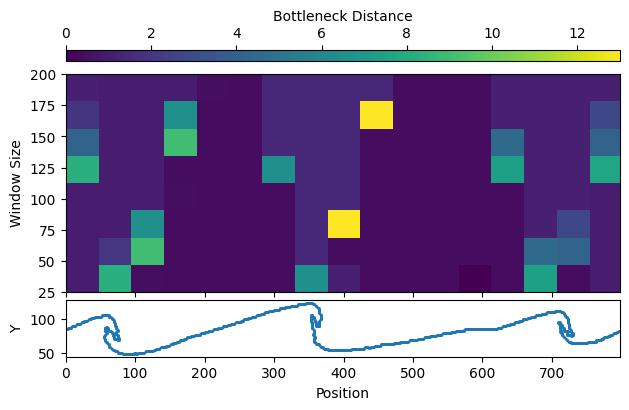

In [156]:
fig, (ax1, ax2) = plt.subplots(2, 1)

# Plot the heatmap
im = ax1.imshow(dists, aspect='auto', origin='lower', extent=[positions.min(), positions.max(), sizes.min(), sizes.max()])
fig.colorbar(im, ax=ax1, label='Bottleneck Distance', orientation='horizontal', location='top', aspect=50)
ax1.set_ylabel('Window Size')
ax1.set_xlim(data[:,0].min(), data[:,0].max()) # Ensure x-axis matches scatter plot
ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# Plot the original data
ax2.scatter(*data.T, s=1)
ax2.set_xlabel('Position')
ax2.set_ylabel('Y')
ax2.set_aspect('equal', adjustable='box')
ax2.set_xlim(data[:,0].min(), data[:,0].max()) # Set x-axis to match heatmap

plt.subplots_adjust(hspace=-0.75)
plt.tight_layout()
plt.show()

In [157]:
videoNum = 0
timestep = -1
# Returns 2D point cloud x,y
data = coasts[list(coasts.keys())[videoNum]][timestep]
dists, positions, sizes = sliding_windows(data, dx=50, maxWindow=200, minWindow=50, step=25)

Positions: [  0  50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800]
Offsets: [ 12.5  25.   37.5  50.   62.5  75.   87.5 100. ]
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800


In [158]:
np.set_printoptions(linewidth=200, precision=2)
print(np.flipud(dists))

[[0.49 0.49 0.42 1.   1.   1.   1.   1.   1.   1.   0.48 0.45 0.43 0.44 0.48 0.49 0.49]
 [0.49 0.49 0.43 1.   1.   1.   1.   1.   1.   1.   0.45 0.45 0.44 0.44 0.44 0.48 0.49]
 [0.49 0.49 0.43 1.   1.   1.   0.46 1.   1.   1.   0.45 0.46 0.42 0.44 0.45 0.48 0.49]
 [0.49 0.49 0.43 0.42 1.   1.   0.47 1.   1.   1.   0.46 0.49 0.42 0.45 0.45 0.49 0.49]
 [0.49 0.42 0.43 0.42 1.   1.   0.48 0.48 1.   0.48 0.47 0.41 0.42 0.45 0.45 0.49 0.49]
 [0.49 0.43 0.44 0.43 1.   1.   0.49 0.49 1.   0.47 0.49 0.41 0.43 0.45 0.47 0.44 0.49]
 [0.49 0.43 0.41 0.43 1.   0.43 0.47 0.47 1.   0.41 0.53 0.41 0.43 0.41 0.45 0.45 0.49]
 [0.48 0.41 0.41 0.41 0.41 0.45 0.41 0.41 1.   0.41 0.49 0.41 0.45 0.41 0.41 0.41 0.48]]


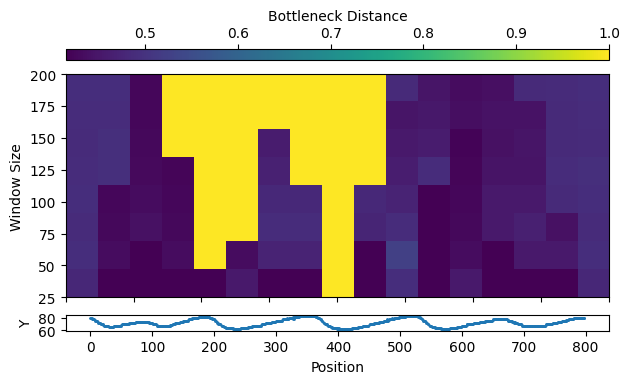

In [159]:
fig, (ax1, ax2) = plt.subplots(2, 1)

# Plot the heatmap
im = ax1.imshow(dists, aspect='auto', origin='lower', extent=[positions.min(), positions.max(), sizes.min(), sizes.max()])
fig.colorbar(im, ax=ax1, label='Bottleneck Distance', orientation='horizontal', location='top', aspect=50)
ax1.set_ylabel('Window Size')
# ax1.set_xlim(data[:,0].min(), data[:,0].max()) # Ensure x-axis matches scatter plot
ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# Plot the original data
ax2.scatter(*data.T, s=1)
ax2.set_xlabel('Position')
ax2.set_ylabel('Y')
ax2.set_aspect('equal', adjustable='box')
# ax2.set_xlim(data[:,0].min(), data[:,0].max()) # Set x-axis to match heatmap

plt.subplots_adjust(hspace=-0.75)
plt.tight_layout()
plt.show()

* I think we need to move the window along the consecutive cells, not across X values
* Why does it seem like the buffer isn't working?? The sandwaves case shouldn't be different on the edges


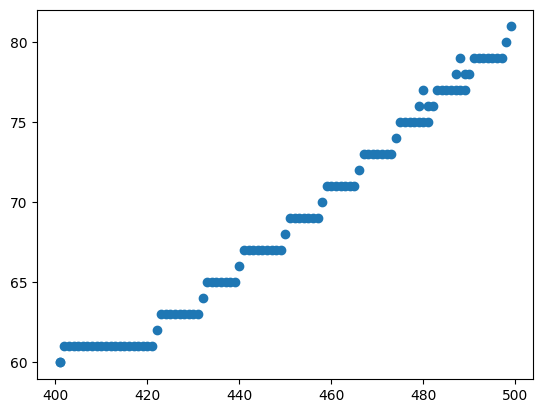

In [152]:
x,y = data.T
xRange = x.max() - x.min()
lbuff, rbuff = data.copy(), data.copy()
lbuff[:, 0] -= xRange
rbuff[:, 0] += xRange
buff = np.vstack((lbuff, data, rbuff))
buffx,buffy = buff.T
pos,offset = 450,50
window = buff[(buffx>pos-offset) & (buffx<pos+offset)]
window[:,1][window[:,0]==window[0,0]] = window[0,1].min()
window[:,1][window[:,0]==window[-1,0]] = window[-1,1].min()
plt.scatter(*window.T)

Looks like we need to select the minimum of the outermost cell in each window